<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   brand                      478 non-null    object 
 1   model                      477 non-null    object 
 2   top_speed_kmh              478 non-null    int64  
 3   battery_capacity_kWh       478 non-null    float64
 4   battery_type               478 non-null    object 
 5   number_of_cells            276 non-null    float64
 6   torque_nm                  471 non-null    float64
 7   efficiency_wh_per_km       478 non-null    int64  
 8   range_km                   478 non-null    int64  
 9   acceleration_0_100_s       478 non-null    float64
 10  fast_charging_power_kw_dc  477 non-null    float64
 11  fast_charge_port           477 non-null    object 
 12  towing_capacity_kg         452 non-null    float64
 13  cargo_volume_l             477 non-null    object 

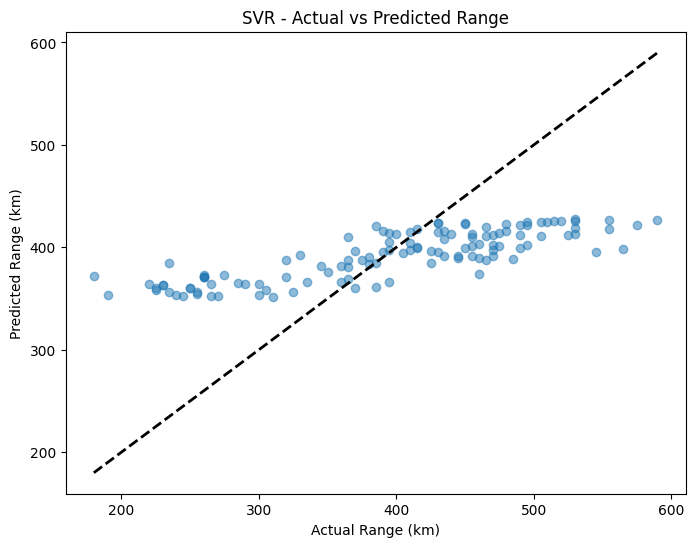

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Load dataset
df = pd.read_csv("electric_vehicles_spec_2025.csv.csv")
df.info()
df.shape, df.head()
# 2. Separate features and target
X = df.drop(columns=["range_km", "source_url", "model"])  # drop target + URL + high-cardinality text
y = df["range_km"]

# 3. Identify categorical & numeric columns
categorical_cols = X.select_dtypes(include=["object"]).columns
numeric_cols = X.select_dtypes(exclude=["object"]).columns

# 4. Preprocessing for numeric features
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

# 5. Preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# 6. Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

# 7. Create SVR pipeline
svr_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("svr", SVR())
])

# 8. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# 9. Fit SVR model
svr_pipeline.fit(X_train, y_train)

# 10. Predictions
y_pred_svr = svr_pipeline.predict(X_test)

# 11. Evaluate
print("SVR - Mean Squared Error:", mean_squared_error(y_test, y_pred_svr))
print("SVR - Mean Absolute Error:", mean_absolute_error(y_test, y_pred_svr))
print("SVR - R-squared:", r2_score(y_test, y_pred_svr))

# 12. Plot predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_svr, alpha=0.5)
plt.xlabel("Actual Range (km)")
plt.ylabel("Predicted Range (km)")
plt.title("SVR - Actual vs Predicted Range")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()
